# SSGP

Port of GPJax's implementation: https://docs.jaxgaussianprocesses.com/_examples/uncollapsed_vi/

From this paper: https://arxiv.org/abs/1309.6835

In [1]:
import os

# XLA_FLAGS="--xla_force_host_platform_device_count=8"

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
import jax

jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

In [2]:
import sys
sys.path.insert(0, "..")

from pymc_experimental.gp import SVGP

import matplotlib.pyplot as plt
import optax
import numpy as np

import pymc as pm
import pytensor
import pytensor.tensor as pt


In [57]:
import pytensor
import pytensor.tensor as pt
import pymc as pm
import numpy as np

import jax
import optax

from pymc.gp.util import stabilize
from pymc.sampling.jax import get_jaxified_graph
from functools import partial


class SVGP:
    def __init__(
        self,
        input_dim,
        n_data,
        batch_size,
        mean_func,
        cov_func,
        sigma,
        z_init,
        variational_sd_dist,
        jitter=1e-6,
    ):
        self.mean_func = mean_func
        self.cov_func = cov_func
        self.sigma = sigma
        self.jitter = jitter

        self.input_dim = input_dim
        self.n_inducing = z_init.shape[0]
        self.n_data = n_data
        self.batch_size = batch_size

        self.z_init = z_init
        self.variational_sd_dist = variational_sd_dist
        
        self.initialize()

    def initialize(self, model=None):
        with pm.modelcontext(model):
            
            self.z = pm.Flat("z", shape=(self.n_inducing, self.input_dim), initval=self.z_init)
            self.variational_mean = pm.Flat("variational_mean", shape=self.n_inducing)
            variational_root_chol, _, _ = pm.LKJCholeskyCov(
                "vrc", n=self.n_inducing, eta=1.0, sd_dist=self.variational_sd_dist,
            )
            #self.z = pm.Normal("z", shape=(self.n_inducing, self.input_dim), initval=self.z_init)
            #self.variational_mean = pm.Normal("variational_mean", shape=self.n_inducing)
            #variational_root_chol, _, _ = pm.LKJCholeskyCov(
            #    "vrc", n=self.n_inducing, eta=1.0, sd_dist=self.variational_sd_dist,
            #)
            #n = self.n_inducing
            #vv = pm.Normal("vv", size =n * (n + 1) // 2)
            #variational_root_chol = pm.expand_packed_triangular(n=n, packed=vv)
            self.variational_root_covariance = variational_root_chol @ variational_root_chol.T

    def kl_divergence(self):
        mu = self.variational_mean
        sqrt = self.variational_root_covariance
        z = self.z

        muz = self.mean_func(z)
        Kzz = self.cov_func(z)
        return self.kl_mvn(mu, sqrt @ sqrt.T, muz, Kzz)
    
    @staticmethod
    def kl_mvn(mu1, K1, mu2, K2):
        # TODO, rewrite to tale in cholesky L1 instead of K1
        d = mu2 - mu1

        K1 = stabilize(K1)
        K2 = stabilize(K2)

        L1 = pt.linalg.cholesky(K1, lower=True)
        L2 = pt.linalg.cholesky(K2, lower=True)

        logdet1 = 2 * pt.sum(pt.log(pt.diag(L1)))
        logdet2 = 2 * pt.sum(pt.log(pt.diag(L2)))

        def solve(B):
            return pt.linalg.solve_triangular(
                L2.T, pt.linalg.solve_triangular(L2, B, lower=True), lower=False
            )

        term1 = pt.trace(solve(K1))
        term2 = logdet2 - logdet1
        term3 = d.T @ solve(d)
        return (term1 + term2 + term3 - d.shape[0]) / 2.0

    def predict(self, t, sigma=None):
        #t = pytensor.printing.Print("t")(t)
        
        # t = X, (n, k)
        mu = self.variational_mean
        sqrt = self.variational_root_covariance
        z = self.z
        #mu = pytensor.printing.Print("mu")(mu)

        muz = self.mean_func(z)
        #muz = pytensor.printing.Print("muz")(muz)
        Kzz = stabilize(self.cov_func(z))
        #Kzz = pytensor.printing.Print("Kzz")(Kzz)
        Lz = pt.linalg.cholesky(Kzz)
        #Lz = pytensor.printing.Print("Lz")(Lz)

        Ktt = stabilize(self.cov_func(t))
        #Ktt = pytensor.printing.Print("Kzt")(Ktt)
        Ktt = Ktt * 1.0
        
        mut = self.mean_func(t)
        Kzt = self.cov_func(z, t)
        #Kzt = pytensor.printing.Print("Kzt")(Kzt)
        
        Lz_inv_Kzt = pt.linalg.solve_triangular(Lz, Kzt, lower=True)  # Lz⁻¹ Kzt
        Kzz_inv_Kzt = pt.linalg.solve_triangular(Lz.mT, Lz_inv_Kzt, lower=False)  # Kzz⁻¹ Kzt
        Ktz_Kzz_inv_sqrt = pt.matmul(Kzz_inv_Kzt.mT, sqrt)  # Ktz Kzz⁻¹ sqrt

        mean = mut + pt.matmul(Kzz_inv_Kzt.mT, mu - muz)  # μt + Ktz Kzz⁻¹ (μ - μz)

        if sigma is None:
            noise = (1e-6)**2 * pt.identity_like(Ktt)
        else:
            noise = sigma**2 * pt.identity_like(Ktt)
        
        covariance = (
            Ktt
            - pt.matmul(Lz_inv_Kzt.mT, Lz_inv_Kzt)
            + pt.matmul(Ktz_Kzz_inv_sqrt, Ktz_Kzz_inv_sqrt.mT)
            + noise
        )
        return mean, covariance
    
    def variational_expectation(self, X_batch, y_batch):

        X_batch = pt.as_tensor(X_batch)
        
        def diag_predict(X_batch):
            mean, cov = self.predict(X_batch)
            return mean, pt.diag(cov)

        #X (100, 3)  k = 3?
        func = pt.vectorize(diag_predict, "(o, k) -> (o), (o)")
        mean, variance = func(pt.expand_dims(X_batch, -2))
        
        #mean = mean.ravel()
        #variance = variance.ravel()

        
        #func = pt.vectorize(self.predict, "(n, k) -> (k), (k, k)")
        #func = pt.vectorize(self.predict, "(n, k) -> (n), (n)")
        #X_batch = pt.as_tensor(X_batch)
        #mean, variance = func(X_batch[..., None])

        #mean, cov = func(X_batch)

        #mean = pytensor.printing.Print("mean_p")(mean)
        #variance = pytensor.printing.Print("variance_p")(variance)
        #mean = mean.ravel()
        #variance = pt.diag(cov).ravel()

        
        
        #X_batch = pt.as_tensor(X_batch)
        #mean, cov = self.predict(X_batch)
        #mean = mean.ravel()
        #variance = pt.diag(cov).ravel()
        
        ## integrate expectation
        sq_error = pt.square(y_batch - mean)
        expectation = -0.5 * pt.sum(
            pt.log(2.0 * pt.pi) + pt.log(self.sigma**2) + (sq_error + variance) / self.sigma**2, axis=1
        )
        return expectation

    def elbo(self, X_batch, y_batch):
        var_exp = self.variational_expectation(X_batch, y_batch)
        #n, b = X.shape[0].eval(), X.shape[0]
        return (self.n_data / self.batch_size) * pt.sum(var_exp).squeeze() - self.kl_divergence()

    def fit(self, X_data, y_data, optimizer, params=None, n_steps=100_000, model=None):
        
        if X_data.ndim != 2 or y_data.ndim != 2:
            raise ValueError("no")
        
        with pm.modelcontext(model) as model:
            loss = -self.elbo(model["X"], model["y"])
            training_step = make_training_step_fn(model, loss, optimizer, self.input_dim, batch_size=self.batch_size)

        if params is None:
            initial_point = model.initial_point()
            params = tuple(initial_point.values())
        
        optimizer_state = optimizer.init(params)
        var_names = model.initial_point().keys()

        loss_history = []
        for step in range(n_steps):
            try:
                batch_slice = np.random.choice(self.n_data, size=self.batch_size, replace=False)
                params, optimizer_state, loss_value = training_step(
                    X_data[batch_slice, :],
                    y_data[batch_slice, :],
                    params,
                    optimizer_state,
                )
                if (len(loss_history) > 1) and (loss_value < loss_history[-1]):
                    best_params = params
                
                loss_history.append(loss_value)
    
                if step % 100 == 0:
                    print(f"Iteration: {step}, Loss: {loss_value:.2f}", end="\r")
            
            except KeyboardInterrupt:
                break
            
        print(f"Iteration: {step + 1}, Loss: {loss_value:.2f}, finished.", end="\r")
        return best_params, loss_history

    def compile_pred_func(self, sigma=None, diag=False, mode="FAST_RUN", model=None):
        t = pt.tensor("t", shape=(None, self.input_dim))

        if diag:
            def diag_predict(X):
                mean, cov = self.predict(X, sigma=sigma)
                return mean, pt.diag(cov)
            
            func = pt.vectorize(diag_predict, "(o, k) -> (o), (o)")
            #mu, cov = func(t[..., None]) # cov is actually a variance
            mu, cov = func(pt.expand_dims(t, -2))
        else:
            mu, cov = self.predict(t, sigma=sigma)
       
        
        with pm.modelcontext(model) as model:
            mu_value, cov_value = model.replace_rvs_by_values([mu, cov])
        
        inputs = pm.inputvars([mu_value, cov_value])
        f_predict = pytensor.function(
            inputs=inputs,
            outputs=[mu_value.squeeze(), cov_value.squeeze()],
            on_unused_input="ignore",
            mode=mode,
        )
        return partial(
            self._predict_f,
            inputs=inputs,
            f_predict=f_predict,
        )

    def _predict_f(self, X_pred, result_dict, inputs, f_predict):
        input_names = [x.name for x in inputs]
        mu_pred, cov_pred = f_predict(
            **{k: v for k, v in result_dict.items() if k in input_names}, t=X_pred
        )
        return mu_pred, cov_pred


def make_training_step_fn(
    model,
    loss,
    optimizer,
    input_dim,
    batch_size=512,
    n_devices=1,
):
    point = model.initial_point()
    [loss_w_values] = model.replace_rvs_by_values([loss])
    # [loss2], joined_inputs = pm.pytensorf.join_nonshared_inputs(
    #    point=point, outputs=[loss_w_values], inputs=model.continuous_value_vars# + pm.inputvars(loss) # for pt.tensor
    # )
    # replace X, y with their minibatch
    X_batch = pt.tensor("X_batch", shape=(batch_size, input_dim))
    y_batch = pt.tensor("y_batch", shape=(batch_size, 1))

    X, y = model["X"], model["y"]
    loss2 = pytensor.graph.graph_replace(
        loss_w_values,
        replace={
            X: X_batch,
            y: y_batch,
        },
    )

    
    # to have in pytensor not jax:
    # loss2 = pymc.pytensorf.rewrite_pregrad(loss2) 
    # grad = pt.grad(loss2, model.continue_value_vars)
    #  f_value_and_grad = pytensor.function(inputs=[X_batch, ...], ouputs = [loss2, grad], **compile_kwargs)
    
    f_loss_jax = get_jaxified_graph(
        [X_batch, y_batch, *model.continuous_value_vars], outputs=[loss2]
    )
    #f_loss_jax = pytensor.function(
    #    [X_batch, y_batch, *model.continuous_value_vars],
    #    outputs=[loss2],
    #    mode='JAX'
    #)

    def f_loss(X, y, params):
        #print("two", X.shape, y.shape, len(params))
        return f_loss_jax(X, y, *params)[0]

    # @partial(jax.pmap, axis_name="device")
    @jax.jit
    def training_step(X, y, params, optimizer_state):
        
        #print("one", X.shape, y.shape)
        loss, grads = jax.value_and_grad(f_loss, 2)(X, y, params)

        ## with partial(jax.pmap), comment if that decor is gone
        # loss = jax.lax.psum(loss, axis_name="device")
        # grads = jax.lax.psum(grads, axis_name="device")

        updates, optimizer_state = optimizer.update(grads, optimizer_state, params)

        params = optax.apply_updates(params, updates)
        return params, optimizer_state, loss

    return training_step

# Example data

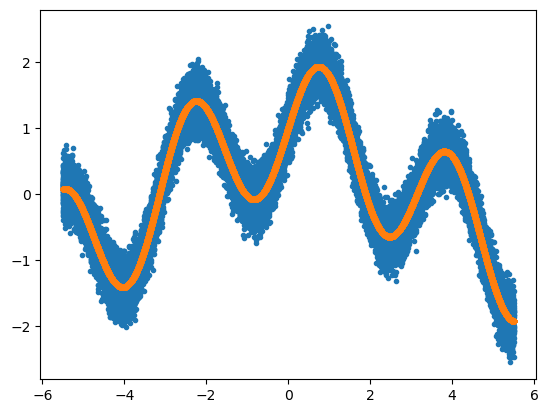

In [58]:
n_data = 50_000
noise = 0.2

low, high = -5.5, 5.5
x = np.sort(np.random.uniform(low, high, n_data))
f = lambda x: np.sin(2 * x) + np.cos(0.5 * x)
signal = f(x)
y = signal + noise * np.random.randn(n_data)

X, y = x[:, None], y[:, None]

plt.plot(x, y, '.');
plt.plot(x, signal, '.');

# Model and fit

In [59]:
with pm.Model() as model:
    pm.Data("X", np.asarray(X))
    pm.Data("y", np.asarray(y))

    eta = pm.Exponential("eta", scale=5.0)
    ell = pm.InverseGamma("ell", mu=1.0, sigma=1.0, initval=0.25)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    c = pm.Exponential("c", scale=5)
    mean_func = pm.gp.mean.Constant(c)

    n_inducing = 15
    #z_init = np.linspace(-5, 5, n_inducing)[:, None]
    z_init = pm.gp.util.kmeans_inducing_points(n_inducing, np.asarray(X))
    z_init = np.sort(z_init, axis=0)
                                              
    sigma = pm.Exponential("sigma", scale=5.0)

    batch_size = 1024
    svgp = SVGP(
        input_dim=X.shape[1],
        n_data=y.shape[0],
        batch_size=batch_size,
        mean_func=mean_func,
        cov_func=cov_func,
        sigma=sigma,
        z_init=z_init,
        variational_sd_dist=pm.HalfStudentT.dist(sigma=1, nu=6),
    )
            
    initial_point = model.initial_point()
    params = tuple(initial_point.values())

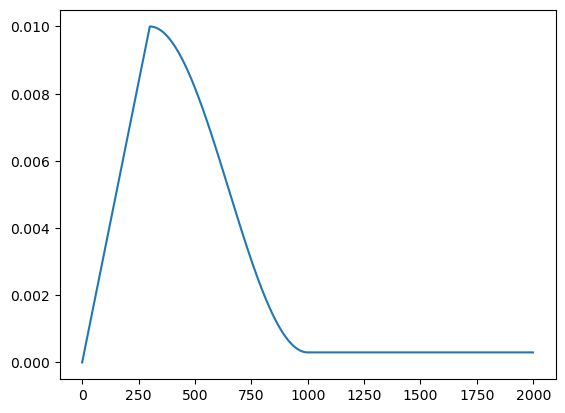

In [60]:
with model:

    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=0.01,
        warmup_steps=300,
        decay_steps=1000,
        end_value=3e-4,
    )
    
    n_steps = 2_000
    plt.plot(schedule(np.arange(n_steps)))
    plt.show()
    
    optimizer = optax.adam(learning_rate=schedule)

    params, history = svgp.fit(X, y, optimizer, params=params, n_steps=n_steps)

var_names = model.initial_point().keys()
result = dict(zip(var_names, params))

# Prediction

In [61]:
str_value_transforms = {value.name: (rv.name, model.rvs_to_transforms[rv]) for rv, value in model.rvs_to_values.items()}
var_names = model.initial_point().keys()
results_dict = {name: np.asarray(param) for name, param in zip(var_names, params)}
results = {}
for name_tr, (name, transform) in str_value_transforms.items():
    if transform is None:
        results[name] = results_dict[name_tr]
    else:
        results[name] = transform.backward(pt.as_tensor(results_dict[name_tr])).eval()

In [62]:
t = np.linspace(-6, 7, 200)[:, None]

sigma = results["sigma"] # or set sigma = None to not have likelihood noise

with model:
    f_predict = svgp.compile_pred_func(sigma=sigma, diag=True)

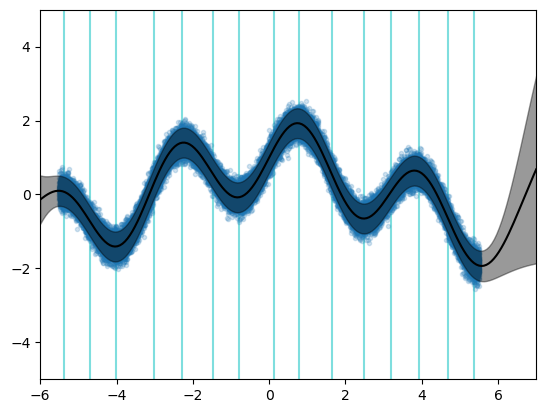

In [63]:
mu, var = f_predict(t, result)
mu = mu.squeeze()
sd = np.sqrt(var).squeeze()

plt.plot(x, y, '.', zorder=0, alpha=0.2);
plt.plot(t.flatten(), mu, color="k");
plt.fill_between(t.flatten(), mu - 2*sd, mu + 2*sd, color="k", alpha=0.4, zorder=1);
plt.xlim([-6, 7]);
plt.ylim([-5, 5]);

z = results["z"].flatten()
for z_ in z:
    plt.axvline(x=z_, color="c", zorder=-2, alpha=0.5)

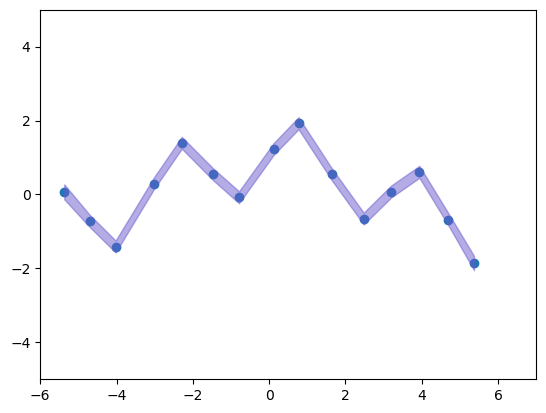

In [64]:
mu = results["variational_mean"].flatten()
plt.scatter(z, mu);

L = pm.expand_packed_triangular(n=n_inducing, packed=pt.as_tensor(results["vrc"])).eval()
Sigma = L.dot(L.T)
sd = np.sqrt(np.diag(Sigma))
plt.fill_between(z, mu - 2*sd, mu + 2*sd, color="slateblue", alpha=0.5);
plt.xlim([-6, 7]);
plt.ylim([-5, 5]);

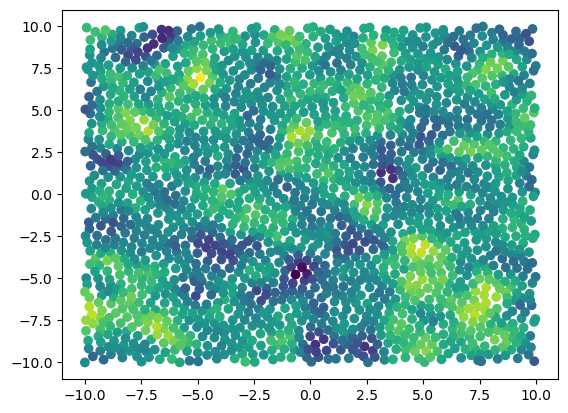

In [79]:
def simulate_2d(
    beta0_true,
    beta1_true,
    ell_true,
    eta_true,
    sigma_true,
):
    seed = sum(map(ord, "hsgp"))
    rng = np.random.default_rng(seed)
    
    # Create the 2d X locations
    from scipy.stats import qmc

    sampler = qmc.Sobol(d=2, scramble=False, optimization="lloyd")
    X = 20 * sampler.random_base2(m=11) - 10.0

    # Draw one sample from the underlying GP
    n = X.shape[0]
    cov_func = eta_true**2 * pm.gp.cov.Matern52(2, ell_true, active_dims=[0, 1])
    gp_true = pm.MvNormal.dist(mu=np.zeros(n), cov=cov_func(X))
    f_true = pm.draw(gp_true, draws=1, random_seed=rng)

    # Add the fixed effects
    mu = f_true

    # The observed data is the latent function plus a small amount
    # of Gaussian distributed noise.
    noise_dist = pm.Normal.dist(mu=0.0, sigma=sigma_true)
    y_obs = mu + pm.draw(noise_dist, draws=n, random_seed=rng)
    return y_obs[:, None], f_true, mu, X


y_data, f_true, mu, X_data = simulate_2d(1, 1, 1.0, 1.0, 0.1)
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data);


with pm.Model() as model:
    pm.Data("X", np.asarray(X_data))
    pm.Data("y", np.asarray(y_data))

    eta = pm.Exponential("eta", scale=1.0)
    ell = pm.InverseGamma("ell", mu=1.0, sigma=1.0)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell)

    c = pm.Exponential("c", scale=10)
    mean_func = pm.gp.mean.Constant(c)

    n_inducing = 25
    z_init = pm.gp.util.kmeans_inducing_points(n_inducing, np.asarray(X_data))
                                              
    sigma = pm.Exponential("sigma", scale=10)

    batch_size = 1024
    svgp = SVGP(
        input_dim=X_data.shape[1],
        n_data=X_data.shape[0],
        batch_size=batch_size,
        mean_func=mean_func,
        cov_func=cov_func,
        sigma=sigma,
        z_init=z_init,
        variational_sd_dist=pm.HalfStudentT.dist(sigma=1, nu=6),
    )
            
    initial_point = model.initial_point()
    params = tuple(initial_point.values())

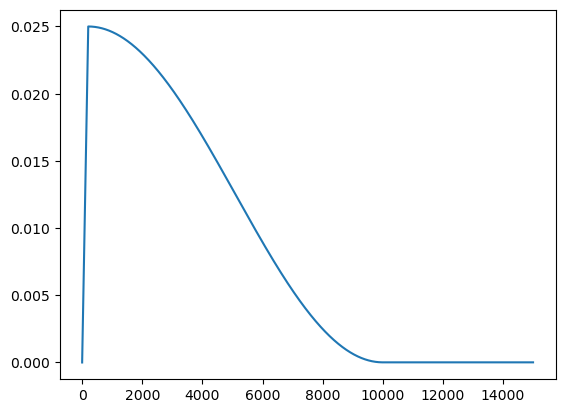

In [80]:
with model:

    schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=0.025,
        warmup_steps=200,
        decay_steps=10_000,
        end_value=1e-5,
    )
    
    n_steps = 15_000
    plt.plot(schedule(np.arange(n_steps)))
    plt.show()
    
    optimizer = optax.adam(learning_rate=schedule)

    params, history = svgp.fit(X_data, y_data, optimizer, params=params, n_steps=n_steps)

var_names = model.initial_point().keys()
result = dict(zip(var_names, params))

In [81]:
str_value_transforms = {value.name: (rv.name, model.rvs_to_transforms[rv]) for rv, value in model.rvs_to_values.items()}
var_names = model.initial_point().keys()
results_dict = {name: np.asarray(param) for name, param in zip(var_names, params)}
results = {}
for name_tr, (name, transform) in str_value_transforms.items():
    if transform is None:
        results[name] = results_dict[name_tr]
    else:
        results[name] = transform.backward(pt.as_tensor(results_dict[name_tr])).eval()

In [82]:
sigma = results["sigma"] # or set sigma = None to not have likelihood noise

with model:
    f_predict = svgp.compile_pred_func(sigma=sigma, diag=True)

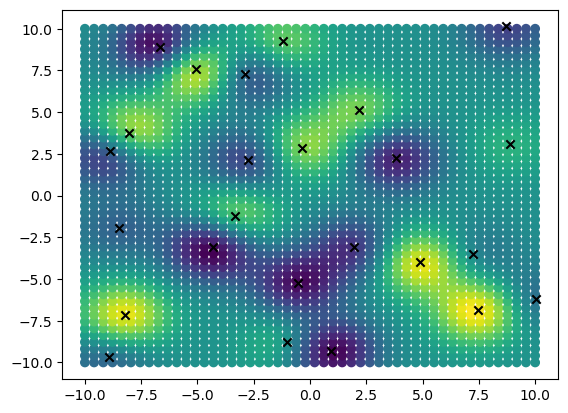

In [83]:
xx1, xx2 = np.meshgrid(np.linspace(-10, 10, 50), np.linspace(-10, 10, 50))
X_pred = np.concatenate((xx1.flatten()[:, None], xx2.flatten()[:, None]), axis=1)


mu, var = f_predict(X_pred, result)
mu = mu.squeeze()
sd = np.sqrt(var).squeeze()

z = results["z"]

plt.scatter(X_pred[:, 0], X_pred[:, 1], c=mu);
plt.scatter(z[:, 0], z[:, 1], marker="x", color="k");

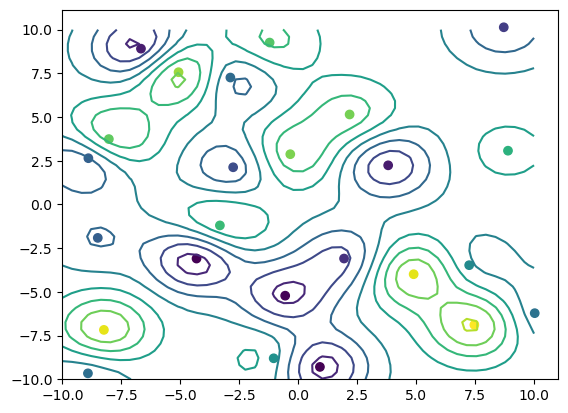

In [85]:
plt.scatter(z[:, 0], z[:, 1], c=results["variational_mean"]);
plt.contour(X_pred[:, 0].reshape(50, 50), X_pred[:, 1].reshape(50, 50), mu.reshape(50, 50));

In [43]:
t = np.linspace(-6, 7, 200)[:, None]

sigma = results["sigma"] # or set sigma = None to not have likelihood noise

with model:
    f_predict = svgp.compile_pred_func_sd(sigma=sigma)

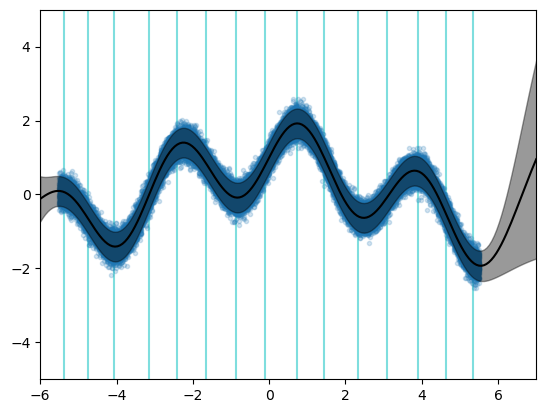

In [44]:
mu, sd = f_predict(t, result)

plt.plot(x, y, '.', zorder=0, alpha=0.2);
plt.plot(t.flatten(), mu, color="k");
plt.fill_between(t.flatten(), mu - 2*sd, mu + 2*sd, color="k", alpha=0.4, zorder=1);
plt.xlim([-6, 7]);
plt.ylim([-5, 5]);

z = results["z"].flatten()
for z_ in z:
    plt.axvline(x=z_, color="c", zorder=-2, alpha=0.5)